In [1]:
from pathlib import Path

import causaldata
import numpy as np
import pandas as pd
import scipy as sp
from sklift.datasets import fetch_lenta

/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chapter2 Dataset作成

## Lenta Datasetを用いたA/Bテストデータ

In [2]:
path = Path("../data/lenta_dataset.csv")

if path.exists() is False:
    dataset = fetch_lenta()
    df = dataset.data.assign(
        treatment=dataset.treatment,
        response_att=dataset.target,
        is_treatment=lambda dfx: dfx.treatment.apply(
            lambda x: {"control": 0, "test": 1}[x]
        ),
        is_women=lambda dfx: np.where(dfx.gender == "Ж", 1, 0),
    )[
        [
            "is_treatment",
            "response_att",
            "food_share_15d",
            "age",
            "is_women",
        ]
    ].sample(
        n=50000, random_state=0
    )

    df.to_csv(path, index=False)

df = pd.read_csv(path)

In [3]:
df.head(5)

,is_treatment,response_att,food_share_15d,age,is_women
0,1,0,0.0000,33.0,1
1,0,0,0.0000,63.0,1
2,1,0,0.0000,51.0,1
3,0,0,0.0000,38.0,1
4,1,0,0.5105,20.0,1


In [4]:
path_log = Path("../data/ch2_logdata.csv")

df_log = df[
    ((df.food_share_15d < 0.5) & (df.is_treatment == 1))
    | (df.is_treatment == 0)
]
df_log.to_csv(path_log, index=False)

In [5]:
df_log.head(5)

,is_treatment,response_att,food_share_15d,age,is_women
0,1,0,0.000,33.0,1
1,0,0,0.000,63.0,1
2,1,0,0.000,51.0,1
3,0,0,0.000,38.0,1
5,0,0,0.931,25.0,0


# Chapter 3

## A/Aテストデータ

In [6]:
def gen_simulated_data(
    n: int, delta: float, seed: int = 1
) -> pd.DataFrame:
    rng = np.random.default_rng(seed=seed)
    uids = np.arange(n)
    assignments = rng.choice([0, 1], size=n)
    ctr_0 = np.clip(rng.uniform(0, 1, size=n), 0, 1)
    ctr_1 = np.clip(rng.uniform(0, 1, size=n) + delta, 0, 1)
    ctrs = np.where(assignments == 1, ctr_1, ctr_0)
    clicks = (rng.uniform(0, 1, size=n) < ctrs).astype(int)
    df = pd.DataFrame(
        np.c_[uids, assignments, clicks],
        columns=["uid", "is_treatment", "is_click"],
    ).astype({"uid": int, "is_treatment": int, "is_click": int})
    return df

In [7]:
path_aatest_trial = Path("../data/ch3_aatest_trial.csv")
df_aatest_trial = gen_simulated_data(n=10000, delta=0, seed=0)
df_aatest_trial.to_csv(path_aatest_trial, index=False)
df_aatest_trial.head(100)

,uid,is_treatment,is_click
0,0,1,0
1,1,1,0
2,2,1,1
3,3,0,1
4,4,0,1
...,...,...,...
95,95,1,0
96,96,0,0
97,97,0,0
98,98,0,0


## クラスターA/Aテストデータ

In [8]:
def gen_cluster_simulated_data(
    cluster_size: int, delta: float, seed: int = 1
) -> pd.DataFrame:
    # setup cluster information
    rng = np.random.default_rng(seed=seed)
    uids = np.arange(cluster_size)
    num_visits = rng.integers(low=1, high=100, size=cluster_size)
    assignments = rng.choice([0, 1], size=cluster_size)
    ctr_0 = np.clip(rng.uniform(0, 1, size=cluster_size), 0, 1)
    ctr_1 = np.clip(
        rng.uniform(0, 1, size=cluster_size) + delta, 0, 1
    )
    ctrs = np.where(assignments == 1, ctr_1, ctr_0)
    # setup data
    uid_vec = np.repeat(uids, num_visits, axis=0)
    treatment_vec = np.repeat(assignments, num_visits, axis=0)
    ctr_vec = np.repeat(ctrs, num_visits, axis=0)
    # click_vec = np.array([rng.choice([0, 1], p = [1-ctr, ctr]) for ctr in ctr_vec])
    click_vec = (
        rng.uniform(0, 1, size=len(uid_vec)) < ctr_vec
    ).astype(int)
    df = pd.DataFrame(
        np.c_[uid_vec, treatment_vec, click_vec],
        columns=["uid", "is_treatment", "is_click"],
    ).astype({"uid": int, "is_treatment": int, "is_click": int})
    return df

In [9]:
path_cluster_trial = Path("../data/ch3_cluster_trial.csv")
df_cluster_trial = gen_cluster_simulated_data(
    cluster_size=200, delta=0, seed=0
)
df_cluster_trial.to_csv(path_cluster_trial, index=False)
df_cluster_trial.head(100)

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
95,1,0,0
96,1,0,0
97,1,0,0
98,1,0,0


## 層化A/Bテスト

In [10]:
def generated_potantial_data(
    num_subgroups: int,
    delta: float,
    group_size: int,
    rng: np.random.Generator,
) -> pd.DataFrame:
    ate = delta
    df = pd.DataFrame()
    for i in range(num_subgroups):
        num_visits = rng.integers(low=1, high=group_size, size=1)
        mean_random_effect = rng.standard_normal(size=1)
        random_effect = rng.normal(loc=mean_random_effect, scale=10)
        y_0 = (
            rng.normal(loc=0, scale=1, size=num_visits)
            + random_effect
        )
        y_1 = (
            rng.normal(loc=ate, scale=1, size=num_visits)
            + random_effect
        )
        df_group = (
            pd.DataFrame(
                np.c_[y_0, y_1], columns=["y_control", "y_treatment"]
            )
            .assign(group_name=i)
            .astype({"y_treatment": float, "y_control": float})
        )
        df = pd.concat([df, df_group], axis=0)
    return df


def stratified_assiginment(
    df_group: pd.DataFrame,
    ratio_treat: float,
    rng: np.random.Generator,
    column_name: str,
) -> pd.DataFrame:
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(
        df_group.index, num_samples, replace=False
    )
    df_group.loc[treat_indices, column_name] = 1
    return df_group


def normal_assiginment(
    df: pd.DataFrame,
    ratio_treat: float,
    rng: np.random.Generator,
    column_name: str,
) -> pd.DataFrame:
    df[column_name] = rng.choice(
        [0, 1], size=df.shape[0], p=[ratio_treat, 1 - ratio_treat]
    )
    return df


def generated_stratified_abtest(
    seed: int, num_subgroups: int, delta: float, group_size: int
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    df = generated_potantial_data(
        num_subgroups, delta, group_size, rng
    )
    df_assigned = (
        df.groupby("group_name")
        .apply(
            stratified_assiginment,
            ratio_treat=0.5,
            column_name="is_treatment",
            rng=rng,
        )
        .reset_index(drop=True)
    )
    df_assigned["y"] = (
        1 - df_assigned["is_treatment"]
    ) * df_assigned["y_control"] + df_assigned[
        "is_treatment"
    ] * df_assigned[
        "y_treatment"
    ]
    return df_assigned[["is_treatment", "group_name", "y"]]


def generated_normal_abtest(
    seed: int, num_subgroups: int, delta: float, group_size: int
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    df = generated_potantial_data(
        num_subgroups, delta, group_size, rng
    )
    df_assigned = normal_assiginment(
        df, 0.5, rng, column_name="is_treatment"
    )
    df_assigned["y"] = (
        1 - df_assigned["is_treatment"]
    ) * df_assigned["y_control"] + df_assigned[
        "is_treatment"
    ] * df_assigned[
        "y_treatment"
    ]
    return df_assigned[["is_treatment", "group_name", "y"]]

In [11]:
path_stratified_trial = Path("../data/ch3_stratified_trial.csv")
# path_stratified_trial_normal_ab = Path('../data/ch3_stratified_trial_normal_ab.csv')  ## 本文では使用しないデータ

df_stratified = generated_stratified_abtest(
    seed=2, num_subgroups=2, delta=0.5, group_size=100
)
df_normal = generated_normal_abtest(
    seed=2, num_subgroups=2, delta=0.5, group_size=100
)

df_stratified.to_csv(path_stratified_trial, index=False)
# df_normal.to_csv(path_stratified_trial_normal_ab, index=False)  ## 本文では使用しないデータ
df_stratified

,is_treatment,group_name,y
0,0,0,-7.094851
1,0,0,-2.853676
2,1,0,-3.024156
3,1,0,-4.989469
4,1,0,-2.724840
...,...,...,...
104,0,1,-9.971287
105,1,1,-10.593688
106,1,1,-6.990840
107,0,1,-7.833720


### 分析結果を確認

In [12]:
df_stratified

,is_treatment,group_name,y
0,0,0,-7.094851
1,0,0,-2.853676
2,1,0,-3.024156
3,1,0,-4.989469
4,1,0,-2.724840
...,...,...,...
104,0,1,-9.971287
105,1,1,-10.593688
106,1,1,-6.990840
107,0,1,-7.833720


In [13]:
df_stratified.groupby(["group_name", "is_treatment"]).count()

y
group_name is_treatment    
0          0             41
           1             42
1          0             13
           1             13

In [14]:
df_normal.groupby(["group_name", "is_treatment"]).count()

y
group_name is_treatment    
0          0             55
           1             28
1          0             11
           1             15

In [15]:
import statsmodels.formula.api as smf

result = smf.ols("y ~ is_treatment", data=df_normal).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.3440,0.299,-17.855,0.000,-5.937,-4.751
is_treatment,-0.6603,0.477,-1.386,0.169,-1.605,0.284


In [16]:
result = smf.ols(
    "y ~ is_treatment + C(group_name)", data=df_stratified
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.7373,0.141,-33.649,0.000,-5.016,-4.458
C(group_name)[T.1],-5.2247,0.216,-24.182,0.000,-5.653,-4.796
is_treatment,0.5301,0.184,2.878,0.005,0.165,0.895


### 念の為A/Aテストをして確認

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.15it/s]


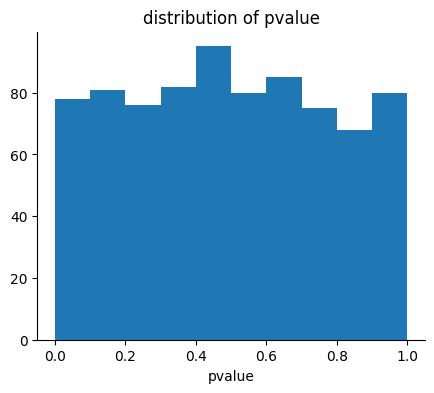

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

df_aatest = df_stratified.copy()
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(800)):
    # 擬似的な割当
    rng = np.random.default_rng(i)
    df_aatest = (
        df_aatest.groupby("group_name")
        .apply(
            stratified_assiginment,
            ratio_treat=0.5,
            column_name="is_treatment_in_aa",
            rng=rng,
        )
        .reset_index(drop=True)
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        "y ~ is_treatment_in_aa + C(group_name)", data=df_aatest
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

## 施策と割当の不一致

In [18]:
def generate_noncompliance_abtest(
    n: int, purchase_control: int, delta: int, seed: int = 1
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    assignments = rng.choice([0, 1], size=n)
    x = rng.normal(loc=0, scale=0.1, size=n)
    winrate = np.clip(rng.uniform(0, 1, size=n) + x, 0, 1)
    is_deliver_1 = (rng.uniform(0, 1, size=n) < winrate).astype(int)
    is_deliver = np.where(assignments == 1, is_deliver_1, 0)
    purchase0 = (
        np.clip(
            rng.normal(loc=purchase_control, scale=1000, size=n),
            0,
            1e6,
        )
        + 10000 * x
    )
    purchase1 = (
        np.clip(
            rng.normal(
                loc=purchase_control + delta, scale=1000, size=n
            ),
            0,
            1e6,
        )
        + 10000 * x
    )
    purchase = np.where(
        (assignments == 1) & (is_deliver_1 == 1), purchase1, purchase0
    )
    df = pd.DataFrame(
        np.c_[assignments, x, is_deliver, purchase],
        columns=["assignment", "x", "is_deliver", "purchase"],
    )
    return df

In [19]:
path_noncompliance = Path("../data/ch3_noncompliance_abtest.csv")

df_noncompliance = generate_noncompliance_abtest(
    n=1000, purchase_control=10000, delta=500, seed=1
)
df_noncompliance.to_csv(path_noncompliance, index=False)
df_noncompliance

,assignment,x,is_deliver,purchase
0,0.0,0.017286,0.0,10563.182011
1,1.0,-0.037921,1.0,8861.781424
2,1.0,0.056103,0.0,11450.231477
3,1.0,-0.213583,0.0,8357.833101
4,0.0,0.023237,0.0,10755.016507
...,...,...,...,...
995,0.0,-0.082353,0.0,9127.673875
996,0.0,-0.108672,0.0,9919.530298
997,1.0,-0.125113,0.0,9469.139734
998,1.0,0.140215,1.0,11103.908090


# Chapter 4

In [20]:
path_organ_donations_short = Path(
    "../data/ch4_organ_donations_short.csv"
)


df_organ_donations_short = (
    causaldata.organ_donations.data.load_pandas()
    .data.pipe(lambda dfx: dfx[dfx["Quarter_Num"].isin([3, 4])])
    .assign(
        IsTreatmentGroup=lambda dfx: np.where(
            dfx["State"] == "California", 1, 0
        ),
        AfterTreatment=lambda dfx: np.where(
            dfx["Quarter_Num"] > 3, 1, 0
        ),
        IsTreatment=lambda dfx: dfx["IsTreatmentGroup"]
        * dfx["AfterTreatment"],
    )
)
df_organ_donations_short.to_csv(
    path_organ_donations_short, index=False
)

In [21]:
path_organ_donations_full = Path(
    "../data/ch4_organ_donations_full.csv"
)

df_organ_donations_full = (
    causaldata.organ_donations.data.load_pandas().data.assign(
        IsTreatmentGroup=lambda dfx: np.where(
            dfx["State"] == "California", 1, 0
        ),
        AfterTreatment=lambda dfx: np.where(
            dfx["Quarter_Num"] > 3, 1, 0
        ),
        IsTreatment=lambda dfx: dfx["IsTreatmentGroup"]
        * dfx["AfterTreatment"],
    )
)
df_organ_donations_full.to_csv(path_organ_donations_full, index=False)